Many thanks to the 2016 Decemberist class and the many insightful comments.
Due to the lack of a joystick this model was trained entirely off the test data set provide by Udacity.

Size of data set 11780


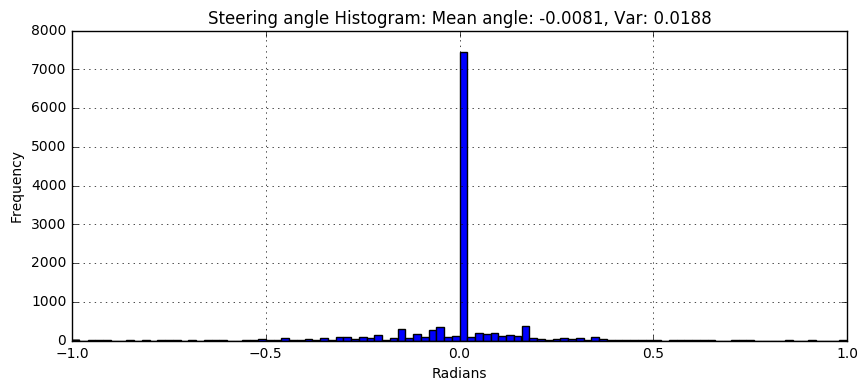

In [35]:
#Data exploration
import random
import cv2
import numpy as np
import pandas as pd
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import math
import os
import cv2
import math
import numpy as np
import pandas as pd
import csv
import time
import argparse
import json

#Load data
d_f = pd.read_csv('data/driving_log.csv')

def hist_plot(d_f):
    print("Size of data set", len(d_f))
    #Get steering and accelaration details
    steer_rad= d_f['steering'].tolist()
    #throttle = d_f['throttle'].tolist()
    #Mean
    ave_steer = np.mean(steer_rad)
    var_steer = np.var(steer_rad)
    #Variance
    #ave_throt = np.mean(throttle)
    #var_throt =np.var(throttle)

    #Plot histograms
    plt.figure(figsize=(10,4))
    d_f.steering.hist(bins=100, color='b')
    plt.title("Steering angle Histogram: Mean angle: {0:.4f}, Var: {1:.4f}".format(ave_steer, var_steer))
    plt.xlabel("Radians")
    plt.ylabel("Frequency")
    plt.show()
    %matplotlib inline 
hist_plot(d_f)

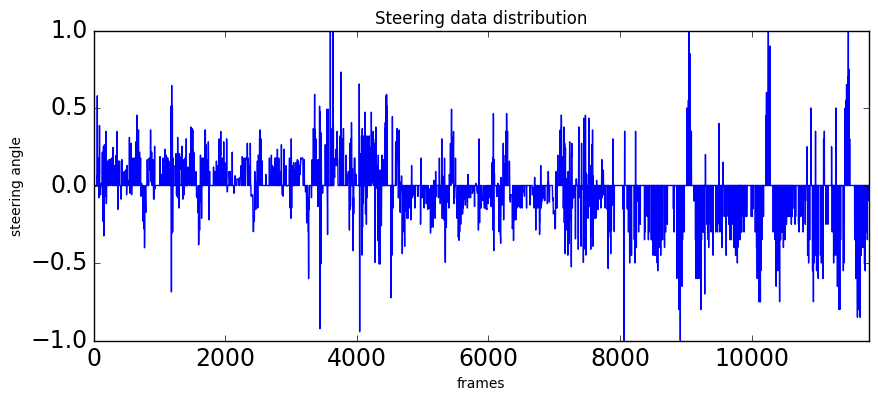

In [36]:
#plot steering angles over first track
d_f.steering.plot(title='Steering data distribution', fontsize=17, figsize=(10,4), color= 'b')
plt.xlabel('frames')
plt.ylabel('steering angle')
plt.show()

In [37]:
#Count number of 0.0 steering angles
acc_zero = d_f['steering']
non_zero  = np.count_nonzero(acc_zero)
total_zero = len(acc_zero) - non_zero
print("Total number of zero acceleration entries: {0}, total number of other entries: {1}".format(total_zero, non_zero))

Total number of zero acceleration entries: 7352, total number of other entries: 4428


As can be seen from the above frequencies, the data set is very skewed towards xero angles and right turns. To balance out the data set, 80% of all these values are dropped so as to stop the model to-be from being biased towards this values.

Size of data set 4874


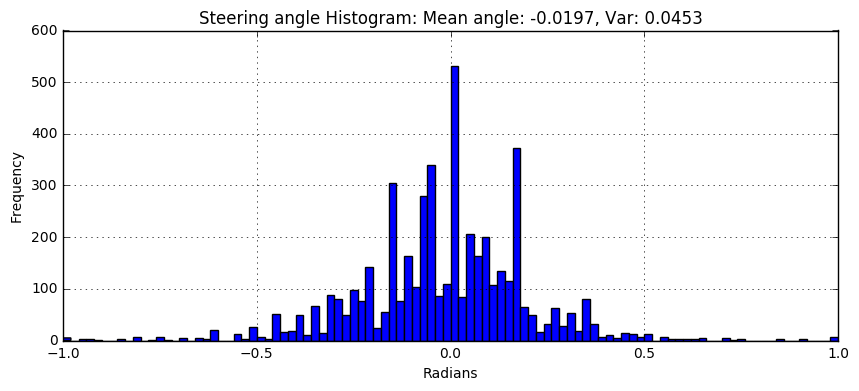

In [38]:
#Drop 90% of zero angle data
drop = int(0.1*total_zero)

#Get non-zero and zero entries
df_n = d_f[d_f.steering != 0]
df_z = d_f[d_f.steering == 0]
df_z = df_z.ix[:drop]

#Augment new entries with non-zero angle entries
new_culled_dataset = pd.concat([df_z, df_n])
hist_plot(new_culled_dataset)
#new_dataset = d_f

In [39]:
#Make sure that we can correctly augment data to the training set by adding flipped images to data set
def make_data_symmetrical(df):
    records = []
    for index, row in df.iterrows():
        left = row.left
        center = row.center
        right = row.right
        steering = row.steering
        
        records.append({
            'image': left,
            'steering': steering + 0.23
        })
        
        records.append({
            'image': right,
            'steering': steering - 0.23
        })
        
        records.append({
            'image': center,
            'steering': steering
        })
    
    return pd.DataFrame(data=records, columns=['image', 'steering'])

new_drive_log = make_data_symmetrical(new_culled_dataset)
new_drive_log.tail()

,image,steering
14617,C:\Users\Kiarie\Documents\SDC_Nano_degree\Beha...,-0.58
14618,C:\Users\Kiarie\Documents\SDC_Nano_degree\Beha...,-0.35
14619,C:\Users\Kiarie\Documents\SDC_Nano_degree\Beha...,0.13
14620,C:\Users\Kiarie\Documents\SDC_Nano_degree\Beha...,-0.33
14621,C:\Users\Kiarie\Documents\SDC_Nano_degree\Beha...,-0.10


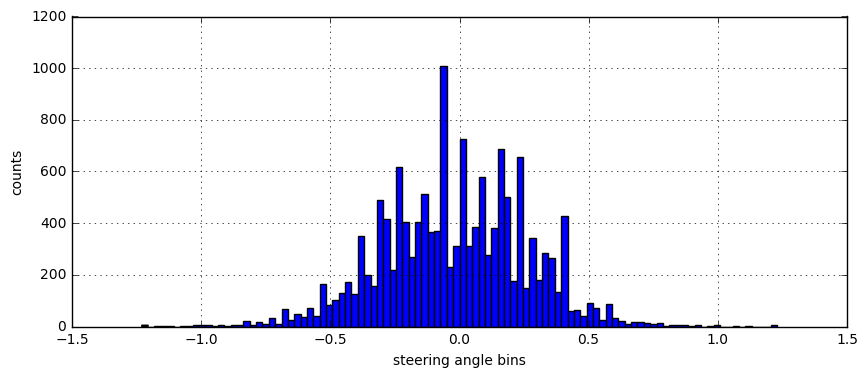

Current Dataset Size:  14622


In [40]:
plt.figure(figsize=(10,4))
new_drive_log.steering.hist(bins=100, color='b')
plt.xlabel('steering angle bins')
plt.ylabel('counts')
plt.show()
print("Current Dataset Size: ", len(new_drive_log.steering))

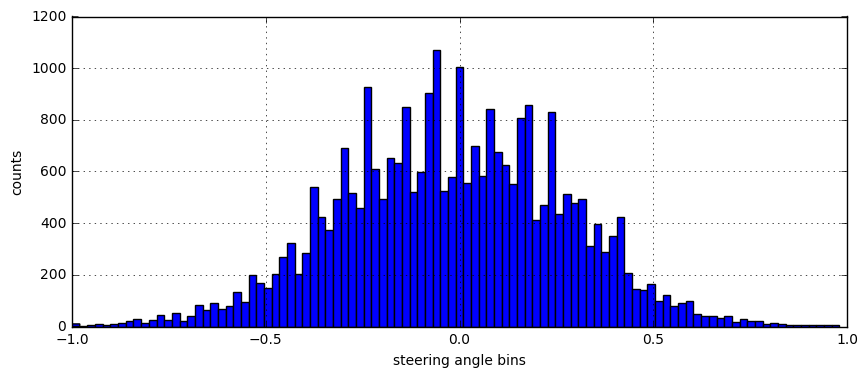

Current Dataset Size:  28716


In [57]:
def shift_img_augmentation(df):
    df.loc[:,'random_shift'] = 0
    new_df = df[df.steering != 0].copy()
    df.loc[:,'is_shift'] = False
    new_df.loc[:,'is_shift'] = True
    
    
    max_shift = 30
    max_ang = 0.17
    
    def row_shift_update(row):
        random_shift = np.random.randint(-max_shift, max_shift + 1)
        row.random_shift = random_shift
        updated_steer = row.steering + (random_shift / max_shift) * max_ang
        if abs(updated_steer) > 1:
            updated_steer = -1 if (updated_steer < 0) else 1

        row.steering = updated_steer
        return row

    new_df = new_df.apply(row_shift_update, axis=1)
    return pd.concat([df, new_df])
#Remove all steering values beyond the bounds [-1, 1]
shifted = shift_img_augmentation(new_drive_log)
shifted = shifted[abs(shifted.steering)<1]
plt.figure(figsize=(10,4))
shifted.steering.hist(bins=100, color='b')
plt.xlabel('steering angle bins')
plt.ylabel('counts')
plt.show()
print("Current Dataset Size: ", len(shifted.steering))

shifted.tail(1)
plt.show()

In [59]:
#Balance dataset as much as possible
hist, counts = np.histogram(shifted.steering, bins=100)
upper_limit = 400
over = [(i, v) for i, v in enumerate(hist) if v > upper_limit ]
over_ranges = [(counts[i],counts[i+1]) for i,_ in over]

#loop through ranges and create a mask for each bin 
masks = ["shifted[(shifted.steering >= {0}) & (shifted.steering < {1})]".format(l,r) for l,r in over_ranges]

for mask in masks:
    selected = eval(mask)
    selected_length = len(selected)
    frac_to_drop = abs((selected_length-upper_limit)/selected_length)
    samples_to_drop = selected.sample(frac=frac_to_drop)
    shifted= shifted.drop(samples_to_drop.index)

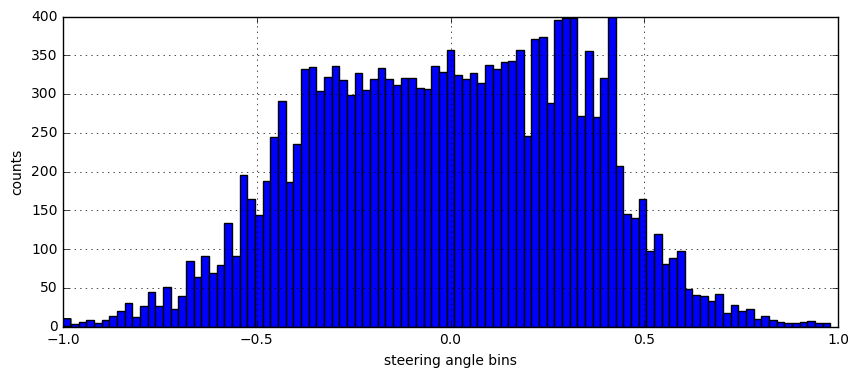

Current Dataset Size:  17612


In [60]:
plt.figure(figsize=(10,4))
shifted.steering.hist(bins=100, color='b')
plt.xlabel('steering angle bins')
plt.ylabel('counts')
plt.show()
print("Current Dataset Size: ", len(shifted.steering))

Size of data set 5771


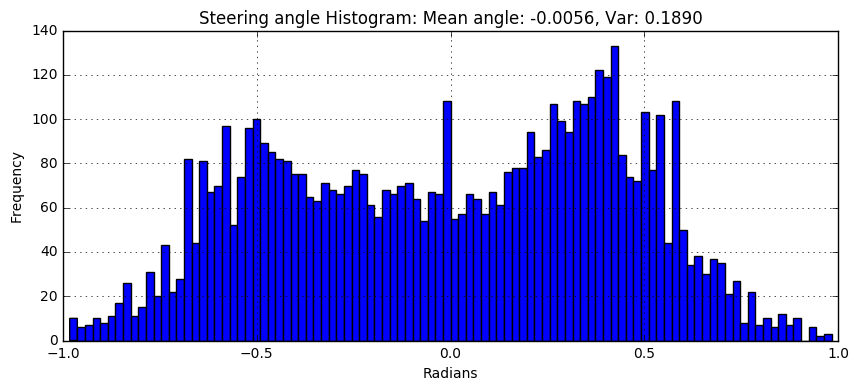

Size of data set 642


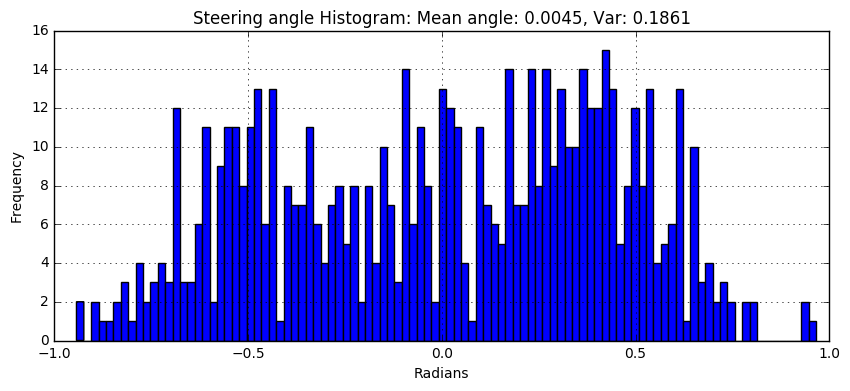

In [50]:
#Split data into train and test sets
from sklearn.model_selection import train_test_split
train, test = train_test_split(shifted, test_size = 0.10)
hist_plot(train)
hist_plot(test)

In [51]:
#Save data set to CSV file
shifted.to_csv('balanced_driver_log.csv')

In [52]:
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers import Dense, Dropout, Flatten, Lambda, Activation, ELU
from keras.optimizers import Adam
from keras.callbacks import Callback
import matplotlib.image as mpimg
#Load data
d_f = pd.read_csv('data/balanced_driver_log.csv')
ANGLE_OFFSET = 0.25

# Angle offsets applied to center, left and right image
ANGLE_OFFSETS = [0.0, ANGLE_OFFSET, -ANGLE_OFFSET]

# Batch size
BATCH_SIZE = 64

In [53]:
import cv2
import numpy as np
def preprocess_input(x):
    FINAL_IMG_SHAPE = (66, 200, 3)

    height = x.shape[0]
    width = x.shape[1]

    factor = float(FINAL_IMG_SHAPE[1]) / float(width)

    resized_size = (int(width*factor), int(height*factor))
    x = cv2.resize(x, resized_size)
    crop_height = resized_size[1] - FINAL_IMG_SHAPE[0]

    return x[crop_height:, :, :]

In [54]:
def random_horizontal_flip(x, y):
    flip = np.random.randint(2)

    if flip:
        x = cv2.flip(x, 1)
        y = -y

    return x, y

def random_translation(img, steering):
    # Maximum shift of the image, in pixels
    trans_range = 50  # Pixels

    # Compute translation and corresponding steering angle
    tr_x = np.random.uniform(-trans_range, trans_range)
    steering = steering + (tr_x / trans_range) * ANGLE_OFFSET

    # Warp image using the computed translation
    rows = img.shape[0]
    cols = img.shape[1]

    M = np.float32([[1,0,tr_x],[0,1,0]])
    img = cv2.warpAffine(img,M,(cols,rows))

    return img, steering

def data_augmentation(x, y):
    # Random horizontal shift
    x, y = random_translation(x, y)

    # Random flip
    x, y = random_horizontal_flip(x, y)

    return x, y

Since we are dealing with a limited data set, I augmented the data set with random translations to make the model robust to randomness. Additionally given that there are more right turns than left, the image data set is also reflected to make the training data more symetrical.

These data augmentation functions are then passed onto generator functions as the combined augmented data set is over the memory limits of the AWS GPU.

In [55]:
def train_generator(X,y, batch_size):
    """ Provides a batch of images from a log file. The main advantage
        of using a generator is that we do not need to read the whole log file,
        only one batch at a time, so it will fit in RAM.
        This function also generates extended data on the fly. """
    # Supply training images indefinitely
    while 1:
        # Declare output data
        x_out = []
        y_out = []
        
        # Fill batch
        for i in range(0, batch_size):
            # Get random index to an element in the dataset.
            idx = np.random.randint(len(y))
            if(X[idx][:2].strip()=="C:"):
                x_i = cv2.imread(X[idx].strip())
            else:
                x_i = cv2.imread("./data/{0}".format(X[idx].strip()))
                
            #print(x_i)
            #x_i = mpimg.imread("data/"+X[idx].strip())
            
            y_i = y[idx]

            # Preprocess image
            x_i = preprocess_input(x_i)

            # Augment data
            x_i, y_i = data_augmentation(x_i, y_i)

            # Add to batch
            x_out.append(x_i)
            y_out.append(y_i)

        yield (np.array(x_out), np.array(y_out))

In [56]:
def val_generator(X, y):
    """ Provides images for validation. This generator is different
        from the previous one in that it does **not** perform data augmentation:
        it just reads images from disk, preprocess them and yields them """
    # Validation generator
    while 1:
        for i in range(len(y)):
            # Read image and steering angle
            if(X[i][:2].strip()=="C:"):
                x_out = cv2.imread(X[i].strip())
            else:
                x_out = cv2.imread("./data/{0}".format(X[i].strip()))
            
            #x_out = mpimg.imread("data/"+X[i][0].strip())
            y_out = np.array([[y[i]]])

            # Preprocess image
            x_out = preprocess_input(x_out)
            x_out = x_out[None, :, :, :]

            # Return the data
            yield x_out, y_out


def make_multiple(x, number):
    """ Increases x to be the smallest multiple of number """
    return int(math.ceil(float(x) / float(number)) * number)


def normalize(X):
    """ Normalizes the input between -0.5 and 0.5 """
    return X / 255. - 0.5

The implemented neural network is based on the NVIDIA architecture from  http://images.nvidia.com/content/tegra/automotive/images/2016/solutions/pdf/end-to-end-dl-using-px.pdf 

In [29]:

""" Defines the network architecture, following Nvidia's example on:
        http://images.nvidia.com/content/tegra/automotive/images/2016/solutions/pdf/end-to-end-dl-using-px.pdf """
import tensorflow as tf
with tf.device('/cpu:0'):
    # Parameters
    FINAL_IMG_SHAPE = (66, 200, 3)

    input_shape = FINAL_IMG_SHAPE

    weight_init='glorot_uniform'
    padding = 'valid'
    dropout_prob = 0.25

    # Define model
    model = Sequential()

    model.add(Lambda(normalize, input_shape=input_shape, output_shape=input_shape))

    model.add(Convolution2D(24, 5, 5,
                                border_mode=padding,
                                init = weight_init, subsample = (2, 2)))
    model.add(ELU())
    model.add(Convolution2D(36, 5, 5,
                                border_mode=padding,
                                init = weight_init, subsample = (2, 2)))
    model.add(ELU())
    model.add(Convolution2D(48, 5, 5,
                                border_mode=padding,
                                init = weight_init, subsample = (2, 2)))
    model.add(ELU())
    model.add(Convolution2D(64, 3, 3,
                                border_mode=padding,
                                init = weight_init, subsample = (1, 1)))
    model.add(ELU())
    model.add(Convolution2D(64, 3, 3,
                                border_mode=padding,
                                init = weight_init, subsample = (1, 1)))

    model.add(Flatten())
    model.add(Dropout(dropout_prob))
    model.add(ELU())

    model.add(Dense(100, init = weight_init))
    model.add(Dropout(dropout_prob))
    model.add(ELU())

    model.add(Dense(50, init = weight_init))
    model.add(Dropout(dropout_prob))
    model.add(ELU())

    model.add(Dense(10, init = weight_init))
    model.add(Dropout(dropout_prob))
    model.add(ELU())

    model.add(Dense(1, init = weight_init, name = 'output'))

    model.summary()

    # Compile it
    model.compile(loss = 'mse', optimizer = Adam(lr = 0.001))

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_2 (Lambda)                (None, 66, 200, 3)    0           lambda_input_2[0][0]             
____________________________________________________________________________________________________
convolution2d_6 (Convolution2D)  (None, 31, 98, 24)    1824        lambda_2[0][0]                   
____________________________________________________________________________________________________
elu_9 (ELU)                      (None, 31, 98, 24)    0           convolution2d_6[0][0]            
____________________________________________________________________________________________________
convolution2d_7 (Convolution2D)  (None, 14, 47, 36)    21636       elu_9[0][0]                      
___________________________________________________________________________________________

In [30]:
def get_training_data(data):
    X = np.copy(data['image'])
    y = np.copy(data['steering'])
    return X, y

In [31]:
batch_size = 64
X_train, y_train =  get_training_data(train)
X_test, y_test =  get_training_data(test)

In [33]:
with tf.device('/cpu:0'):    
    n_train_samples = 5 * make_multiple(len(y_train), batch_size)
    n_val_samples = len(y_test)
    n_epochs = 1
    gen_train = train_generator(X_train, y_train, batch_size)
    gen_val = val_generator(X_test, y_test)


    model.fit_generator(generator = gen_train,
                            samples_per_epoch = n_train_samples,
                            validation_data = gen_val,
                            nb_val_samples = n_val_samples,
                            nb_epoch = n_epochs,

                            verbose = 1)

Epoch 1/1
27200/27200 [==============================] - 272s - loss: 0.0937 - val_loss: 0.0707


In [34]:
#Save final model as specified in Udacity ruberic
# serialize model to JSON
model_json = model.to_json()
with open("../../model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save('../../model.h5') 
print("Saved model to disk")

Saved model to disk
